In [44]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table
from lsd import DB 
from lsd.bounds import beam, rectangle
from lsd.join_ops import Query
import os

In [32]:
os.environ['NWORKERS'] = '8' # note: value has to be a string (number of cores we allow it to run on)
os.environ['LSD_CACHEDIR'] = os.environ['HOME'] + '/tempdir' 
os.environ['LSD_TEMPDIR'] = os.environ['HOME'] + '/tempdir'
os.environ["LSD_DB"] = os.environ['HOME'] + "/lsddb:/astro/apps6/opt/lsddb"


In [20]:
db = DB(os.environ['LSD_DB'])

In [243]:
# sending a query in the local sdss database for stars with g-r < 0.4 and 20 < r <= 22.0
bounds_xy = rectangle(100, -5, 240, 60) 
rows = db.query('select sdss_id, ra, dec, g - gExt as g, r - rExt as r, \
                gErr, rErr, flags, flags2 from sdss where (g-r < 0.4) & \
                (r <= 22.0) & (r > 20) & (type == 6)').fetch(bounds=[(bounds_xy, None)])

 [607 el.]WARNING:lsd.pool2:Error contacting lsd-manager. Cannot coordinate resource usage with others, using 8 cores.
::::::::::::::::::::>  25.94 sec


In [244]:
# turning the results of the query into a table and defining variables to be used later
field = Table(rows.as_ndarray())
g = field['g']
r = field['r']
gr = field['g'] - field['r']
ra = field['ra']
dec = field['dec']

In [315]:
# masks for r bins
blue_mask = (20.0 < r) & (r <= 20.66)
green_mask = (20.66 < r) & (r <= 21.33)
red_mask = (21.33 < r) & (r <= 22.0)

# creating the extent and bins such that the dimensions of the bins are 0.5x0.5 degrees
xbins = (max(ra) - min(ra)) / 0.5
ybins = (max(dec) - min(dec)) / 0.5
x_edges = np.arange(min(ra), max(ra), 0.5)
y_edges = np.arange(min(dec), max(dec), 0.5)

# creating 2d histograms for each r bin
blue_hist, blue_x, blue_y = np.histogram2d(ra[blue_mask], dec[blue_mask], \
                            bins = (xbins, ybins), \
                            range = [[min(ra), max(ra)], [min(dec), max(dec)]])
red_hist, red_x, red_y = np.histogram2d(ra[red_mask], dec[red_mask], \
                            bins = (xbins, ybins), \
                            range = [[min(ra), max(ra)], [min(dec), max(dec)]])
green_hist, green_x, green_y = np.histogram2d(ra[green_mask], dec[green_mask], \
                            bins = (xbins, ybins), \
                            range = [[min(ra), max(ra)], [min(dec), max(dec)]])


In [316]:
# stream is the matrix that will be imaged using imshow. The first 2 dimensions are 
# intentionally zeros. The third dimension is an array of length 3 that holds the [R,G,B] 
# information which will be translated to a color in imshow. 
stream = np.zeros(shape=(129, 279, 3))
for i in range(len(x_edges)-1):
    for j in range(len(y_edges)-1):
        # multiplying by 4 to get units of square degree (from 0.25 square degrees)
        red = 4.0* red_hist[i][j]
        green = 4.0*green_hist[i][j]
        blue = 4.0*blue_hist[i][j]
        # for each color bin: only choosing a specific range (as described by Fig. 1)
        # and then normalizing accordingly
        if ((102 < red) and (red <= 330)):
            stream[j][i][0] = (red-102.0) / (330.0-102.0)
        if (107 < green) & (green <= 304):
            stream[j][i][1] = (green - 107.0) / (304.0 - 107.0)
        if (98.0 < blue) & (blue <= 267.0):
            stream[j][i][2] = (blue - 98.0) / (267.0-98.0)
        

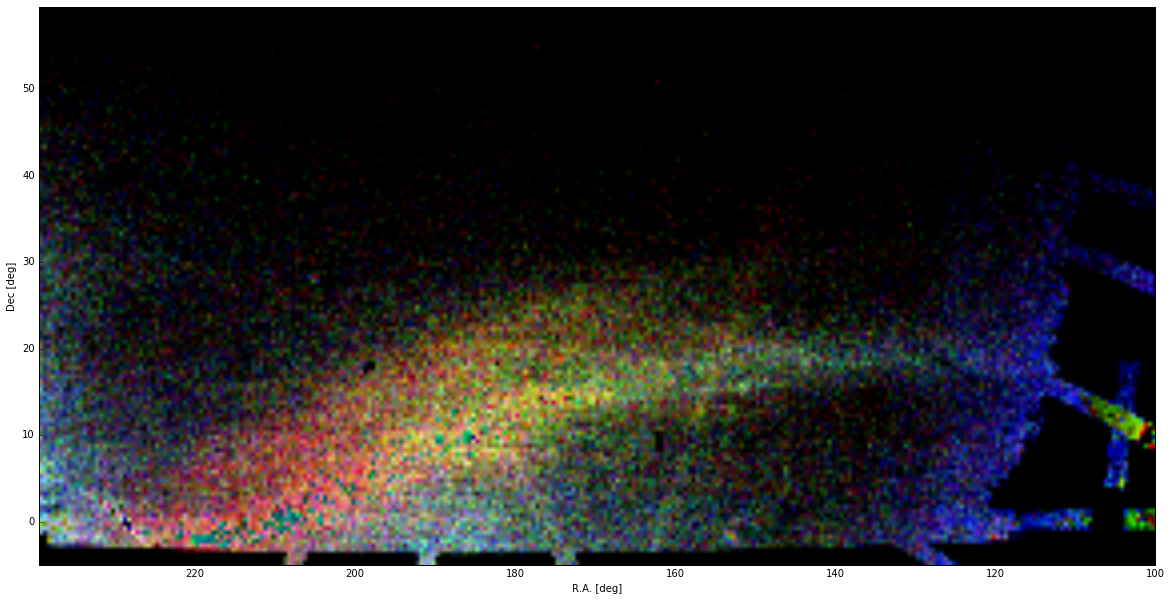

In [319]:
# plotting the stream!
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(np.fliplr(stream), aspect='auto',origin = 'lower', \
          extent = [x_edges[-1], x_edges[0], y_edges[0], y_edges[-1]])
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec [deg]')
